# Quantum benchmark

## I - Introduction

## II - Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, KFold
#Import classical libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
import logging

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
import qiskit

In [2]:
import warnings
warnings.filterwarnings('ignore')

## III - Data 

In [52]:
# Read out CSV

df = pd.read_csv('UCI_Credit_Card.csv', sep=',')

In [3]:
%%script false --no-raise-error

import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

## IV - Modelisation

## Quantum Approaches

In [4]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [55]:
from sklearn.decomposition import TruncatedSVD

In [56]:
np.unique(df_labels)

array([0, 1])

In [57]:
from sklearn.preprocessing import StandardScaler

In [58]:
# Standardizing the features
x = StandardScaler().fit_transform(X_train)

In [59]:
qla = TruncatedSVD(n_components=2)

In [60]:
qla.fit(x)

TruncatedSVD()

In [61]:
df_qla = qla.transform(x)

In [62]:
principalDf = pd.DataFrame(data = df_qla
             , columns = ['principal component 1', 'principal component 2'])

In [63]:
principalDf.head()

,principal component 1,principal component 2
0,0.613781,-0.523776
1,-0.683219,-1.312404
2,-1.696564,0.055426
3,0.021401,-0.827255
4,2.449152,0.472863


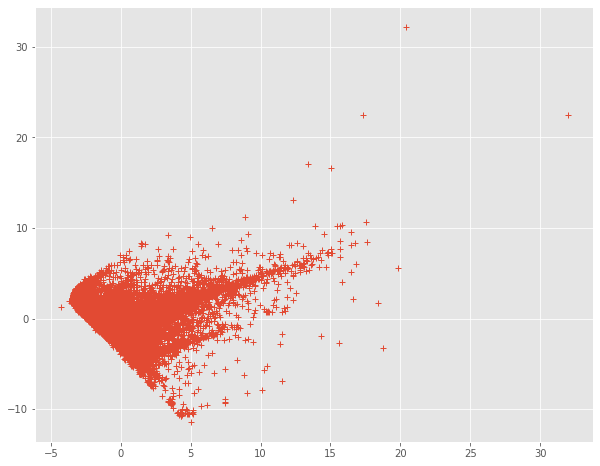

In [64]:
plt.figure(figsize=(10,8))
plt.plot(principalDf.iloc[:,0], principalDf.iloc[:,1], '+')
#plt.plot(df.index, feature_2, 'g+')

In [65]:
n_dim = len(principalDf.columns)

## Split train test 

In [67]:
# Split dataset into train and test

sample_train, sample_test, label_train, label_test = train_test_split(
     principalDf, y_train, test_size=0.2, random_state=22)

# Normalize

std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale for better fit within the feature map

samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select a sample for a better control of the research and wall time

train_size = 800#160
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 200 #40
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [5]:
# Basic parameters for hybrid model

seed = 8500
feature_dim = n_dim
num_reps = 2
num_shots =256 


## Hybrid

In [69]:
# Define feature_map

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=num_reps)

# Define the backend
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=num_shots, seed_simulator=seed, seed_transpiler=seed
)

# Define the kernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

# Model run
svc = SVC(kernel=kernel.evaluate)
svc.fit(sample_train, label_train)
score = svc.score(sample_test, label_test)

print(f"Callable kernel classification test score: {score}")

Callable kernel classification test score: 0.81


In [70]:
result_predict = svc.predict(sample_test)

In [71]:
print(metrics.classification_report(label_test,result_predict))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       160
           1       1.00      0.05      0.10        40

    accuracy                           0.81       200
   macro avg       0.90      0.53      0.49       200
weighted avg       0.85      0.81      0.73       200



In [90]:
_df = pd.DataFrame()
_models = []
_models.append(('qsvc',svc))
_metrics = ['precision', 'recall', 'f1', 'accuracy',  'matthews_corrcoef','balanced_accuracy']
for metric in _metrics:
    _df= pd.concat([_df, evaluate_ml_model(_models, sample_train, label_train, n_fold=10, metric=metric)], axis=1)

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is i

KeyboardInterrupt: 

In [ ]:
df_results[['precision mean (%)', 'precision std (%)', 'recall mean (%)',
       'recall std (%)', 'f1 mean (%)', 'f1 std (%)',  'balanced_accuracy mean (%)','matthews_corrcoef mean (%)',
       'matthews_corrcoef std (%)',
       'balanced_accuracy std (%)']]

## Classical Approaches

In [201]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [ ]:
df_results = pd.DataFrame()

In [209]:
from sklearn.model_selection import cross_validate
def evaluate_ml_model(_models, X, y, n_fold=10, metric='precision'):
    ''' Function to evaluate a ML and QML model with a list of metrics
    
    
    '''
    results = pd.DataFrame()
    kfold = KFold(n_splits=n_fold)
    columns = []
    for name, model in _models:
        # -------------------
        # Variables initialization 
        _df = pd.DataFrame()
        names = []
        means = []
        stds = []
        
        # -------------------
        # k-fold Cross validation
        cv_results = cross_validate(model, X, y, cv=kfold, scoring=metric)
        
        # -------------------
        # Compute the mean and standard deviation 
        for _name, _array in cv_results.items():
            names.append(_name)
            means.append(round(_array.mean(), 5))
            stds.append(round(_array.std(), 5))
        # -------------------
        # Save the results in a dataframe 
        _df =  pd.DataFrame([means, stds], columns=names)
        columns.extend([name+' mean (%)', name+' std (%)'])
        #results = results.join(_df, on=_df.index)
        results = results.append(_df)
    results.index = columns
    print(results)
    return results
             
        

In [211]:
df_results = evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric=_metrics)

               fit_time  score_time  test_precision  test_recall  test_f1  \
LR mean (%)     0.00205     0.00238         0.20000      0.02205  0.03917   
LR std (%)      0.00188     0.00325         0.40000      0.04822  0.08450   
KNN mean (%)    0.00030     0.00198         0.46467      0.25599  0.30894   
KNN std (%)     0.00004     0.00012         0.21408      0.11096  0.09889   
CART mean (%)   0.00104     0.00111         0.36807      0.39106  0.36699   
CART std (%)    0.00006     0.00007         0.08113      0.12957  0.07924   
NB mean (%)     0.00026     0.00108         0.62833      0.20260  0.29335   
NB std (%)      0.00001     0.00001         0.22758      0.08078  0.09981   
SVM mean (%)    0.00436     0.00277         0.76810      0.18318  0.27833   
SVM std (%)     0.00017     0.00013         0.17463      0.09917  0.11739   

               test_accuracy  test_balanced_accuracy  test_matthews_corrcoef  
LR mean (%)          0.76875                 0.51103                 0.05

In [212]:
df_results

,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy,test_balanced_accuracy,test_matthews_corrcoef
LR mean (%),0.00205,0.00238,0.20000,0.02205,0.03917,0.76875,0.51103,0.05977
LR std (%),0.00188,0.00325,0.40000,0.04822,0.08450,0.05653,0.02411,0.12299
KNN mean (%),0.00030,0.00198,0.46467,0.25599,0.30894,0.74375,0.57645,0.19115
KNN std (%),0.00004,0.00012,0.21408,0.11096,0.09889,0.05923,0.05713,0.13416
CART mean (%),0.00104,0.00111,0.36807,0.39106,0.36699,0.69625,0.59219,0.17688
CART std (%),0.00006,0.00007,0.08113,0.12957,0.07924,0.05838,0.06612,0.11147
NB mean (%),0.00026,0.00108,0.62833,0.20260,0.29335,0.78000,0.58135,0.25556
NB std (%),0.00001,0.00001,0.22758,0.08078,0.09981,0.04077,0.04056,0.11110
SVM mean (%),0.00436,0.00277,0.76810,0.18318,0.27833,0.79125,0.58189,0.29094
SVM std (%),0.00017,0.00013,0.17463,0.09917,0.11739,0.04712,0.04361,0.09599


## QSVC

In [ ]:
# Be assure that your qiskit version is 0.4.0
# run !pip install --upgrade qiskit==0.4.0 if not 

In [6]:
#%%script false --no-raise-error
# Define feature_map, optimizer and var_form

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
optimizer = COBYLA(maxiter=20, disp=True, rhobeg=1.0, tol=None)
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=3)


# Define the backend

backend = qiskit.Aer.get_backend('qasm_simulator')

# Define the instance

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

# Model run
vqc = QSVC(quantum_kernel=quantum_instance)#optimizer, feature_map, var_form, training_input, test_input, datapoints[0])


result = vqc.fit(sample_train, label_train)



AttributeError: 'QuantumInstance' object has no attribute 'evaluate'

In [1]:
import qiskit
qiskit.__version__

'0.21.1'

In [33]:
!pip3 install --upgrade qiskit #==0.4.0

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


## Pennylane

In [135]:
from pennylane import numpy as np

In [136]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [137]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#print(weights_init, bias_init)

In [138]:
circuit(weights_init, sample_train[0])

tensor(0.31741061, requires_grad=True)

In [139]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [140]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [141]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [142]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [143]:
Y = np.array(label_train * 2 - np.ones(len(label_train)),requires_grad=True)  # shift label from {0, 1} to {-1, 1}
X = np.array(sample_train, requires_grad=True)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(-0.91388051, requires_grad=True), tensor(-0.43605053, requires_grad=True)], Y = -1
X = [tensor(-0.75669993, requires_grad=True), tensor(-0.5130791, requires_grad=True)], Y = -1
X = [tensor(-0.6469136, requires_grad=True), tensor(-0.61851951, requires_grad=True)], Y = -1
X = [tensor(-0.74267366, requires_grad=True), tensor(-0.33589561, requires_grad=True)], Y =  1
X = [tensor(-0.89490901, requires_grad=True), tensor(-0.46560166, requires_grad=True)], Y = -1


In [144]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [146]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0

for it in range(100):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    if accuracy(Y, predictions)  > abest: # metrics.f1_score(Y, predictions, average='binary', pos_label=1)
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions) #metrics.f1_score(Y, predictions, average='binary')
        print('New best')
    prec = accuracy(Y, predictions) #metrics.f1_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | f1: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 0.8372018 | f1: 0.7650000 
Iter:     2 | Cost: 0.7339972 | f1: 0.7650000 
Iter:     3 | Cost: 0.9196479 | f1: 0.7650000 
Iter:     4 | Cost: 1.0364512 | f1: 0.7650000 
Iter:     5 | Cost: 0.8916945 | f1: 0.7650000 
Iter:     6 | Cost: 0.7208163 | f1: 0.7650000 
Iter:     7 | Cost: 0.9676588 | f1: 0.7275000 
Iter:     8 | Cost: 0.9428012 | f1: 0.7525000 
Iter:     9 | Cost: 0.9235088 | f1: 0.7600000 
Iter:    10 | Cost: 0.7660246 | f1: 0.7637500 
New best
Iter:    11 | Cost: 0.7146088 | f1: 0.7662500 
Iter:    12 | Cost: 0.7610595 | f1: 0.7650000 
Iter:    13 | Cost: 0.8238483 | f1: 0.7650000 
Iter:    14 | Cost: 0.8444558 | f1: 0.7650000 
Iter:    15 | Cost: 0.8352446 | f1: 0.7650000 
Iter:    16 | Cost: 0.7835588 | f1: 0.7650000 
Iter:    17 | Cost: 0.7327724 | f1: 0.7662500 
Iter:    18 | Cost: 0.7157238 | f1: 0.7637500 
Iter:    19 | Cost: 0.7505878 | f1: 0.7612500 
Iter:    20 | Cost: 0.7576206 | f1: 0.7612500 
Iter:    21 | Cost: 0.7321096 | f1: 0.7637

In [ ]:
Yte = np.array(label_test * 2 - np.ones(len(label_test)))
Xte = np.array(normalize(sample_test))

In [ ]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

In [86]:
print(metrics.classification_report(predictions,Yte))

              precision    recall  f1-score   support

        -1.0       0.47      0.89      0.61        84
         1.0       0.78      0.27      0.40       116

    accuracy                           0.53       200
   macro avg       0.62      0.58      0.51       200
weighted avg       0.65      0.53      0.49       200



In [87]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')



    Precision: 77.5%
    Recall: 26.72%
    f1: 39.74%
    Accuracy: 53.0%
    Balanced accuracy: 58.0%
    Matthew corcorref: 19.75%
    
